## Gig Economy Project

By: Janet Taylor & Evan Kessler

Workers in the gig economy (i.e., Uber, GrubHub, TaskRabbit, etc.) depend on the reviews they get to continue working on the platform. Workers on those platforms are often affected by receiving negative reviews that describe elements that were not under their control. The project explores how the analysis of online reviews can detect when unfair reviews are left to workers and identify the type of unfair review that was left.

In [16]:
import pandas as pd

In [17]:
uber = pd.read_csv("uber_cleaned.csv")
lyft = pd.read_csv("lyft_cleaned.csv")
pd.options.display.max_colwidth = 500
uber["Review Body"].head()

0    all your driver's we very good, knowledgeable and friendly. however, ellie was exceptional. she established a rapport with my daughter and i in the very short time we were in the car with her. she was helpful, answered our questions about the island and even gave us a few suggestions on places she enjoyed eating. which in fact we did try freda's and it was good. thank you, ellie, for your service, customer service and helpfulness!
1                                                                                                                                                                driver canceled the ride because he couldn’t find us and we were charged $5.  we were waiting for him but he didn’t show up.  when i tried contacting him, i went directly into voicemail but couldn’t leave a message.  had to order another ride and the second driver picked us up.
2                                                                                                                       

In [18]:
uber.columns

uber['Review Body']

0                                                                        all your driver's we very good, knowledgeable and friendly. however, ellie was exceptional. she established a rapport with my daughter and i in the very short time we were in the car with her. she was helpful, answered our questions about the island and even gave us a few suggestions on places she enjoyed eating. which in fact we did try freda's and it was good. thank you, ellie, for your service, customer service and helpfulness!
1                                                                                                                                                                                                                                    driver canceled the ride because he couldn’t find us and we were charged $5.  we were waiting for him but he didn’t show up.  when i tried contacting him, i went directly into voicemail but couldn’t leave a message.  had to order another ride and the second drive

{'the': 8190, 'and': 6556, 'to': 6469, 'i': 5675, 'a': 4446, 'was': 3443, 'driver': 2928, 'uber': 2917, 'my': 2542, 'for': 2273, 'in': 1949, 'of': 1935, 'they': 1763, 'on': 1624, 'is': 1615, 'me': 1507, 'drivers': 1482, 'not': 1476, 'it': 1433, 'that': 1368, 'with': 1334, 'have': 1313, 'he': 1290, 'you': 1274, 'very': 1226, 'had': 1122, 'this': 1076, 'are': 942, 'at': 930, 'but': 916, 'no': 901, 'time': 879, 'we': 868, 'up': 834, 'get': 814, 'an': 807, 'so': 799, 'from': 797, 'be': 796, 'ride': 776, 'as': 771, 'when': 739, 'will': 660, 'then': 648, 'service': 619, 'were': 611, 'if': 595, 'all': 560, 'app': 554, 'use': 540, 'or': 516, 'car': 515, 'just': 504, 'never': 499, 'your': 494, 'their': 480, 'after': 473, 'trip': 459, 'there': 458, 'because': 455, 'been': 454, 'would': 452, 'our': 441, 'got': 440, 'minutes': 437, 'charged': 427, 'even': 426, 'customer': 418, 'one': 404, 'them': 397, 'us': 385, 'do': 378, 'about': 377, 'good': 374, 'cancel': 371, 'out': 369, 'said': 361, 'great':

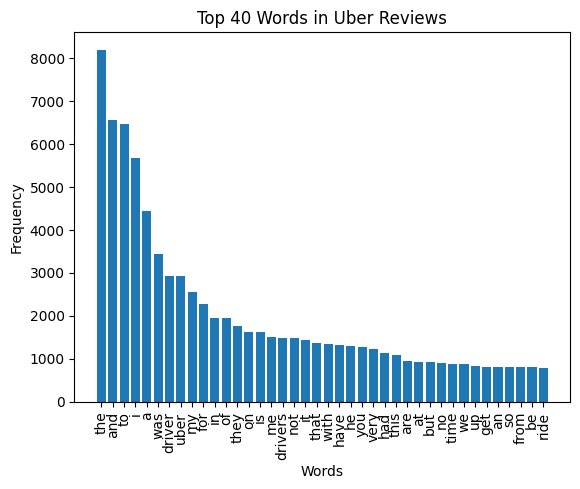

C:\Users\evkes\AppData\Local\Temp\ipykernel_30768\2686197609.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_reviews['the_count'] = the_reviews['Review Body'].str.lower().str.count('the')


,# Reviews By User,User URL,State,Username,Country,Date Review Given,Invited,Review URL,Review Title,Review Body,Date of Experience,Rating,Company,Unfair,the_count
0,3,https://www.trustpilot.com/users/602209d7fe424b001a6b711b,KA,KATHLEEN,US,5 hours ago,True,https://www.trustpilot.com/reviews/63f228859b64b1bdaf5c2063,Ellie was exceptional,"all your driver's we very good, knowledgeable and friendly. however, ellie was exceptional. she established a rapport with my daughter and i in the very short time we were in the car with her. she was helpful, answered our questions about the island and even gave us a few suggestions on places she enjoyed eating. which in fact we did try freda's and it was good. thank you, ellie, for your service, customer service and helpfulness!",2023-02-16,5,Uber,False,3
1,1,https://www.trustpilot.com/users/63f17dca2c3e940012e887fc,TL,Thomas Littleton,US,17 hours ago,True,https://www.trustpilot.com/reviews/63f17dcb9b64b1bdaf5bd0b2,Disappointed,"driver canceled the ride because he couldn’t find us and we were charged $5. we were waiting for him but he didn’t show up. when i tried contacting him, i went directly into voicemail but couldn’t leave a message. had to order another ride and the second driver picked us up.",2023-02-16,3,Uber,False,3
2,1,https://www.trustpilot.com/users/63f1a4db8f66370012afda88,NaN,kumar kanakapura,IN,14 hours ago,False,https://www.trustpilot.com/reviews/63f1a4ef6f3134764b6da9e0,Nasty behavior of Uber auto driver,uber driver complained he does not know the route to destination. refused to talk to my friend who was trying to guide us. dropped me off 10 mins away from destination. demanded payment when it was already paid thro my amex. uber has not cared to respond to my complaints.,2023-02-17,1,Uber,False,1
3,2,https://www.trustpilot.com/users/5d1540199a28935fe625fd9c,TL,tlsg1951,US,2 days ago,True,https://www.trustpilot.com/reviews/63f02b579b64b1bdaf5af878,drivers were great but,"my drivers were great, on time, comfortable people, clean, enjoyed the ride. i would've given 5 stars if the price had been reasonable. a 2 mile 5 minute ride should not cost $27 one way and add a tip!! geez!! then to get home. a reasonable fee would be $12 one way! if it was within my budget would use uber more often.\r\nattn corporate please reconsider pricing for seniors thank you",2023-02-14,4,Uber,True,3
4,2,https://www.trustpilot.com/users/5e35c6d6ddcefa252263845d,TE,Terry,US,2 days ago,True,https://www.trustpilot.com/reviews/63f013789b64b1bdaf5af12a,My debit card was charged twice for a…,"my debit card was charged twice for a pre schedule ride on february 15th. the original driver never made pickup. i was also charged a cancellation fee after i schedule another ride. the issue has not been resolved by uber. i am a very dissatisfied customer. i will never use uber again, i feel i am being scammed.\r\nuber don't send me anymore emails.",2023-02-15,1,Uber,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,7,https://www.trustpilot.com/users/5cf03d7212bf4a10b214fb90,GR,Grzegorz,PL,"Jan 1, 2021",False,https://www.trustpilot.com/reviews/5fef2abb755dc1032c092844,I’m very disappointed with UBER's…,"i’m very disappointed with uber's services. in the morning, tired after work, i waited to get home. several drivers nearby and no one wants to accept the transport order. finally, when after 10 minutes one driver graciously accepted the order, i waited another 10 minutes for him, where he was nearby. i called to ask about the cancellation and the driver tells me he's on his way but not where it needs to be. complete shock and total lack of professionalism.",2021-01-01,1,Uber,NaN,6
3767,1,https://www.trustpilot.com/users/5feec3c0765829001979c50a,NaN,Theresa Nagel,US,"Jan 1, 2021",False,https://www.trustpilot.com/reviews/5feec3c8755dc1032c08ecd5,I had an Uber driver tell me that he…wanted me to suck his dick,i had an uber driver tell me that he wouldn’t take me to the address i wanted to go

In [30]:

# Create a list of all words in the reviews
from collections import Counter
import matplotlib.pyplot as plt

words = [word.lower() for review in uber['Review Body'] for word in review.split()]

# Use Counter to count the occurrence of each word
word_count = Counter(words)

word_freq_dict = {}

for word, freq in sorted(word_count.items(), key=lambda item: item[1], reverse=True):
    word_freq_dict[word] = freq

print(word_freq_dict)

top_words = list(word_freq_dict.keys())[:40]
word_freq = [word_freq_dict[word] for word in top_words]

plt.bar(top_words, word_freq)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 40 Words in Uber Reviews')
plt.show()

app_reviews = uber[uber['Review Body'].str.contains('the', case=False)]
app_reviews['app_count'] = app_reviews['Review Body'].str.lower().str.count('app')

app_reviews

{'the': 8113, 'to': 7074, 'i': 6629, 'and': 6315, 'a': 5496, 'lyft': 3395, 'for': 2985, 'my': 2573, 'is': 2326, 'they': 2274, 'of': 2268, 'was': 2190, 'in': 2128, 'driver': 1991, 'that': 1927, 'have': 1646, 'with': 1639, 'me': 1609, 'you': 1577, 'it': 1577, 'drivers': 1565, 'not': 1564, 'on': 1397, 'this': 1287, 'are': 1217, 'ride': 1184, 'be': 1082, 'he': 1027, 'get': 1024, 'but': 953, 'as': 949, 'up': 913, 'had': 912, 'at': 895, 'their': 853, 'no': 788, 'from': 783, 'when': 780, 'so': 775, 'if': 773, 'will': 709, 'or': 678, 'never': 664, 'we': 648, 'an': 643, 'would': 631, 'time': 625, 'your': 581, 'service': 577, 'there': 551, 'them': 540, 'more': 529, 'about': 524, 'do': 521, 'out': 517, 'use': 515, 'all': 515, 'very': 511, 'company': 505, 'because': 497, 'customer': 497, 'just': 495, 'then': 491, 'been': 488, 'like': 483, 'app': 471, 'car': 460, 'after': 452, 'uber': 450, 'one': 448, 'even': 442, 'only': 425, 'has': 419, 'way': 409, 'can': 407, 'make': 393, 'than': 391, 'got': 390

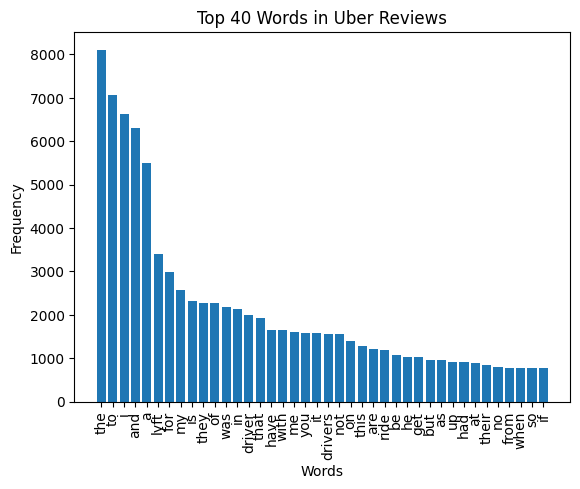

In [24]:

from collections import Counter

words = [word.lower() for review in lyft['Review Body'] for word in review.split()]

# Use Counter to count the occurrence of each word
word_count = Counter(words)

word_freq_dict = {}

for word, freq in sorted(word_count.items(), key=lambda item: item[1], reverse=True):
    word_freq_dict[word] = freq

print(word_freq_dict)

top_words = list(word_freq_dict.keys())[:40]
word_freq = [word_freq_dict[word] for word in top_words]

plt.bar(top_words, word_freq)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 40 Words in Uber Reviews')
plt.show()

